# Project hypotheses

## Localization

Current data come from a supposedly wide audience, since Reddit is a well-known tool in the US.
The first hypothesis states that Reddit utilisation doesn't apply a strong input filtering of the relevant population, thus biasing the dataset towards a subpopulation.
Second hypothesis is that business context and targeted population are sufficiently similar to the dataset population, even if the location is different, such as in France where Reddit has less coverage.

## Time shift

Even if at current state (2022/12/26), r/RAOP rules have strong emphasis on the relative legitimacy (reddit account metadata) of applicants to avoid inappropriate requests, they cannot be taken into account here.
Indeed, they may have evolved over time, which already adds bias to the historical data, but obviously cannot be applied retrospectively now, 9 years later.
Nonetheless, we assume that altruism is a time constant through a wide population.
World-wide economic situation shift over time is also neglected since our business object is a vital food product, 🚀 popular, and still affordable.

## Wisdom of crowds

Even if we disregard the rules process, Reddit structure (comments, votes, account metadata) is assimilated to an influence soft-voting tool.
That's why it's assumed that donation process and request legitimacy are not misplaced, and we're confident about the transfert between RAOP donation purpose and our business objective.
So if a request led to a donation, thus the request was legitimate.

# Business context

## Marketing campaign

I'm running a pizza restaurant at a fast-growing pace with some few localizations.
In order to promote our upcoming additional location, we're launching a marketing campaign to donate some pizza to people who made a request.
It can leverage some pain points:
+ Expand our brand image
+ Minimize unsells waste
+ Donate to people in need

Currently, our resources can't afford to have dedicated people to develop and run this kind of process. Lucky for me, I used to be a Data Scientist and r/RAOP+kaggle gives me data to work with.

## Business objectives

1. Train a model to predict legitimacy *(i.e. pizza donation)* of a request at the moment of request to avoid target leakage.
2. Find a process that doesn't disapprove or lower the previous legitimacy of donation at the moment of data retrieval, if there's such a thing.

## Future concerns

The current depicted design doesn't leverage any concerns about legitimate requests leading to actual donation and marketing performances.
Indeed, legitimate requests could be all fulfilled or partially depending on our selection process, volume, donation supply chain, seasonality, cost efficiency, and many other variables.
For now, the project focus on donation legitimacy modelisation.

# Data preparation

In [1]:
import string
import numpy as np
import pandas as pd
from datetime import datetime as dt
from scipy.stats import f_oneway
import joblib

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, f1_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import xgboost as xgb

from nltk.corpus import stopwords
from nltk import word_tokenize

## Load dataset

In [2]:
pizza_raw_data = pd.read_json('../data/pizza_data.json',
                              dtype={"giver_username_if_known": str,
                                     "number_of_upvotes_of_request_at_retrieval": int,
                                     "post_was_edited": bool,
                                     "request_id": str,
                                     "request_number_of_comments_at_retrieval": int,
                                     "request_text": str,
                                     "request_text_edit_aware": str,
                                     "request_title": str,
                                     "requester_account_age_in_days_at_request": float,
                                     "requester_account_age_in_days_at_retrieval": float,
                                     "requester_days_since_first_post_on_raop_at_request": float,
                                     "requester_days_since_first_post_on_raop_at_retrieval": float,
                                     "requester_number_of_comments_at_request": int,
                                     "requester_number_of_comments_at_retrieval": int,
                                     "requester_number_of_comments_in_raop_at_request": int,
                                     "requester_number_of_comments_in_raop_at_retrieval": int,
                                     "requester_number_of_posts_at_request": int,
                                     "requester_number_of_posts_at_retrieval": int,
                                     "requester_number_of_posts_on_raop_at_request": int,
                                     "requester_number_of_posts_on_raop_at_retrieval": int,
                                     "requester_number_of_subreddits_at_request": int,
                                     "requester_received_pizza": bool,
                                     "requester_subreddits_at_request": list,
                                     "requester_upvotes_minus_downvotes_at_request": int,
                                     "requester_upvotes_minus_downvotes_at_retrieval": int,
                                     "requester_upvotes_plus_downvotes_at_request": int,
                                     "requester_upvotes_plus_downvotes_at_retrieval": int,
                                     "requester_user_flair": str,
                                     "requester_username": str,
                                     "unix_timestamp_of_request": int,
                                     "unix_timestamp_of_request_utc": int})

In [3]:
pizza_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040 entries, 0 to 4039
Data columns (total 32 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   giver_username_if_known                               4040 non-null   object 
 1   number_of_downvotes_of_request_at_retrieval           4040 non-null   int64  
 2   number_of_upvotes_of_request_at_retrieval             4040 non-null   int32  
 3   post_was_edited                                       4040 non-null   bool   
 4   request_id                                            4040 non-null   object 
 5   request_number_of_comments_at_retrieval               4040 non-null   int32  
 6   request_text                                          4040 non-null   object 
 7   request_text_edit_aware                               4040 non-null   object 
 8   request_title                                         4040

The dataset has no missing values, so imputation processes will not be covered in this notebook, but should be considered in a full production-ready pipeline.

## Data leakage prevention

Some features may lead to data leakage.
One is directly linked to pizza donation, `giver_username_if_known`.
Others may be since they aren't concerned about at_request/at_retrieval split-up, such as `requester_user_flair` *(requester badge obtention after receiving a pizza donation)*, `request_text` and `post_was_edited` *(some request posts are edited after getting a pizza donation)*.
So, these features are removed from our project.

In [4]:
pizza_prevented_data = pizza_raw_data.loc[:, ~(pizza_raw_data
                                               .columns
                                               .isin(["giver_username_if_known",
                                                      "requester_user_flair",
                                                      "request_text",
                                                      "post_was_edited"]))
                       ]

## Split training data

In [5]:
target_name = 'requester_received_pizza'
seed = 101
X = pizza_prevented_data.copy()
y = X.pop(target_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed, stratify=y_test)

In [6]:
dataset_period = (dt.strptime("29/09/2013", "%d/%m/%Y") - dt.strptime("08/12/2010", "%d/%m/%Y")).days

print(f'''From our {pizza_raw_data.shape[0]} samples, we'll use {X_train.shape[0]} of them to train the model.
From {len(y_train)} requests, {y_train.sum()} led to a donation, which represents {round(y_train.sum()/len(y_train), 3)*100}%.
Thus, among {dataset_period} days, 1 pizza was donate every {round(dataset_period/y_train.sum(), 2)} day.''')

From our 4040 samples, we'll use 3636 of them to train the model.
From 3636 requests, 895 led to a donation, which represents 24.6%.
Thus, among 1026 days, 1 pizza was donate every 1.15 day.


One request out of four is therefore legitimate according to our statements.

## Dissociate features at request from at retrieval

In order to avoid data leakage, for example a request that had a donation could have a posteriori some upvotes boost, only features at request time are accounted according to the first objective to model legitimacy of a request.

In [7]:
univariate_features = ["unix_timestamp_of_request_utc", #non-utc timestamp is redundant and less convenient
                       "request_title",
                       "request_text_edit_aware"]

at_request_features = []
at_retrieval_features = []

for selected_time, selected_features in {"at_request": at_request_features, "at_retrieval": at_retrieval_features}.items():
    dataset_features = (X_train
                        .filter(regex=f'.*{selected_time}$')
                        .columns
                        .tolist())
    selected_features.extend(dataset_features)

In [8]:
pizza_retrieval_data = X_train[univariate_features + at_retrieval_features]
X_train = X_train[univariate_features + at_request_features]

In [9]:
print(f"{X_train.shape[1]} raw features can be used to predict legitimacy of a request.")

13 raw features can be used to predict legitimacy of a request.


In [10]:
X_train.describe(include="all")

,unix_timestamp_of_request_utc,request_title,request_text_edit_aware,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request
count,3.636000e+03,3636,3636,3636.000000,3636.000000,3636.000000,3636.000000,3636.000000,3636.000000,3636.000000,3636,3636.000000,3.636000e+03
unique,NaN,3625,3538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2683,NaN,NaN
top,NaN,Request,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN
freq,NaN,4,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,667,NaN,NaN
mean,1.342677e+09,NaN,NaN,251.623667,15.827121,115.032178,0.646040,21.363311,0.065457,18.003850,NaN,1163.397690,3.807502e+03
std,2.332738e+07,NaN,NaN,297.644679,67.651509,193.458792,3.323355,50.180486,0.329403,21.648384,NaN,3853.827389,2.707045e+04
min,1.297723e+09,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-173.000000,0.000000e+00
25%,1.320252e+09,NaN,NaN,2.872529,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,3.000000,8.000000e+00
50%,1.342484e+09,NaN,NaN,156.997483,0.000000,24.000000,0.000000,5.000000,0.000000,11.000000,NaN,173.500000,3.505000e+02
75%,1.364254e+09,NaN,NaN,386.092488,0.000000,139.000000,0.000000,22.000000,0.000000,27.000000,NaN,1153.000000,2.290250e+03


# Data exploration
## Let's start first with non-textual data ...

In order to have ground level refrence, let's start with a very basic modelisation with underperforming results.

In [11]:
X_train_num = X_train.select_dtypes(exclude=["object"])
X_val_num = X_val.select_dtypes(exclude=["object"])

In [12]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3636 entries, 1186 to 813
Data columns (total 10 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   unix_timestamp_of_request_utc                       3636 non-null   int32  
 1   requester_account_age_in_days_at_request            3636 non-null   float64
 2   requester_days_since_first_post_on_raop_at_request  3636 non-null   float64
 3   requester_number_of_comments_at_request             3636 non-null   int32  
 4   requester_number_of_comments_in_raop_at_request     3636 non-null   int32  
 5   requester_number_of_posts_at_request                3636 non-null   int32  
 6   requester_number_of_posts_on_raop_at_request        3636 non-null   int32  
 7   requester_number_of_subreddits_at_request           3636 non-null   int32  
 8   requester_upvotes_minus_downvotes_at_request        3636 non-null   int32  


### Feature engineering

Votes give great insights with the sum related to visibility and difference related to consensus/polarisation. However, the 2 variables here are absolute and a relative one is missing.

In [13]:
def add_relative_votes(df, num, den, suffix="request"):
    math_fct = lambda row: row.iloc[1] and row.iloc[0] / row.iloc[1] or 0
    df[f'requester_relative_consensual_votes_at_{suffix}'] = df.copy()[[num, den]].apply(math_fct, axis = 1)

    return df

diff_votes = 'requester_upvotes_minus_downvotes_at_request'
sum_votes = 'requester_upvotes_plus_downvotes_at_request'

X_train_num = add_relative_votes(X_train_num, num=diff_votes, den=sum_votes)
X_val_num = add_relative_votes(X_val_num, num=diff_votes, den=sum_votes)

### Feature importances

In [14]:
def make_mi_scores(x_data, y_data):
    mi_results = mutual_info_classif(x_data, y_data, random_state=seed)
    mi_results = pd.Series(mi_results, name="MI Scores", index=x_data.columns)
    return mi_results

def make_f_oneway_scores(x_data, y_data):
    grp_anova = x_data.groupby(y_data)

    f_values = []
    for feat in x_data.columns:
        s, p = f_oneway(grp_anova.get_group(0)[feat],
                        grp_anova.get_group(1)[feat])
        s = round(s, 4)
        p = round(p, 4)
        f_values.append((s, p))

    f_scores = pd.Series(f_values, name="F_oneway Scores", index=x_data.columns)
    return f_scores

def make_corr_scores(x_data, y_data):
    return x_data.corrwith(y_data)

In [15]:
mi_scores = make_mi_scores(X_train_num, y_train)
f_oneway_scores = make_f_oneway_scores(X_train_num, y_train)
corr_scores = make_corr_scores(X_train_num, y_train)

pd_info = pd.concat([mi_scores, corr_scores, f_oneway_scores], axis='columns')
pd_info.columns =["Mutual Info", "Correlation", "F_oneway (s,p)"]
pd_info

,Mutual Info,Correlation,"F_oneway (s,p)"
unix_timestamp_of_request_utc,0.024898,-0.107105,"(42.1707, 0.0)"
requester_account_age_in_days_at_request,0.000000,0.043291,"(6.8232, 0.009)"
requester_days_since_first_post_on_raop_at_request,0.002130,0.101339,"(37.7071, 0.0)"
requester_number_of_comments_at_request,0.000000,0.034051,"(4.2183, 0.0401)"
requester_number_of_comments_in_raop_at_request,0.013583,0.131384,"(63.8311, 0.0)"
requester_number_of_posts_at_request,0.006105,0.014886,"(0.8055, 0.3695)"
requester_number_of_posts_on_raop_at_request,0.002615,0.138441,"(71.0095, 0.0)"
requester_number_of_subreddits_at_request,0.000011,0.038775,"(5.4718, 0.0194)"
requester_upvotes_minus_downvotes_at_request,0.010255,0.031172,"(3.5346, 0.0602)"
requester_upvotes_plus_downvotes_at_request,0.000000,0.025642,"(2.3909, 0.1221)"


It seems that almost all features have some importance, with `requester_number_of_posts_at_request` being the least important of them.
The previous created `requester_relative_consensual_votes_at_request` feature looks like a good new addition, and beating its creation features.

### Modelisation

Now that we're at the modelisation step, there is one important question, which is what metric to use.
The real subquestion is, in terms of business, what is more prolific and harmless in the fact of donate to a mostly illegitimate request or on contrary not donating to a legitimate request.
The first, a false positive, harms the branding image and financial cost, the other, a false negative, harms notoriety.
But most of all, as described earlier, this algorithm doesn't lead directly to donation. It outputs only so-called legitimacy, which will take a big place in the donation decision but still can be hold back on a decision algorithm.
With that in mind, the main goal should be to minimize false positives with a metric such as precision, as long as false negatives are not numerous.

In [16]:
def create_scaler_preproc(numerical_features, scaler_method = None):
    steps = [('scaler_method', scaler_method)]
    scaler_transformer = Pipeline(steps)

    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('scaler_transformer', scaler_transformer, numerical_features)
        ], remainder='drop')

    # Model pipeline
    steps = [('preproc', preprocessor)]
    proc_pipe = Pipeline(steps)

    return proc_pipe

def create_pipeline(train_set, preproc, estimator, model_name, grid_strat, hyperparameters, n_folds,
                    eval_metric='precision', verbosity=3, n_jobs=10):
    X, y = train_set

    # Model pipeline
    steps = [("preproc", preproc), (model_name, estimator)]
    model_pipe = Pipeline(steps)

    # Grid Search
    cv = grid_strat(model_pipe,
                    param_grid=hyperparameters,
                    cv=n_folds,
                    scoring=eval_metric,
                    n_jobs=n_jobs,
                    verbose=verbosity,
                    random_state=seed)

    grid_model = cv.fit(X, y)

    return grid_model

def print_pipe_results(train_set, val_set, model):
    X_train, y_train = train_set
    yhat = model.best_estimator_.predict(X_train)
    print(f'In samples resutls:\n {classification_report(y_train, yhat)}')
    print()

    X_val, y_val = val_set
    yhat = model.best_estimator_.predict(X_val)
    print(f'Out-of-samples resutls:\n {classification_report(y_val, yhat)}')
    print()
    print(f'''Confusion matrix:
{pd.DataFrame(confusion_matrix(y_val, yhat, normalize='all'),
              columns=["PredNeg", "PredPos"],
              index=["Neg", "Pos"])}''')

#### Logistic Regression

In [17]:
model = LogisticRegression(solver='liblinear',
                           random_state=seed)

model_name = 'logreg'

parameters = {f'{model_name}__C': np.logspace(-2, 1, 50)}

logreg_gridCV = create_pipeline(train_set = [X_train_num, y_train],
                                preproc=create_scaler_preproc(X_train_num.columns, scaler_method=MaxAbsScaler()),
                                estimator = model,
                                model_name = model_name,
                                grid_strat=HalvingGridSearchCV,
                                hyperparameters = parameters,
                                n_folds = 3,
                                eval_metric='precision',
                                verbosity=0)

print()
print_pipe_results(train_set = [X_train_num, y_train],
                   val_set = [X_val_num, y_val],
                   model = logreg_gridCV)


In samples resutls:
               precision    recall  f1-score   support

       False       0.76      0.99      0.86      2741
        True       0.68      0.04      0.08       895

    accuracy                           0.76      3636
   macro avg       0.72      0.52      0.47      3636
weighted avg       0.74      0.76      0.67      3636


Out-of-samples resutls:
               precision    recall  f1-score   support

       False       0.77      1.00      0.87       153
        True       1.00      0.06      0.12        49

    accuracy                           0.77       202
   macro avg       0.88      0.53      0.49       202
weighted avg       0.82      0.77      0.69       202


Confusion matrix:
      PredNeg   PredPos
Neg  0.757426  0.000000
Pos  0.227723  0.014851


Logistic regression doesn't offer great recall performance whatever the tuning.

#### Gaussian Naive Bayes

In [18]:
model = GaussianNB()

model_name = 'gaus_nb'

parameters = {}

gaussnb_gridCV = create_pipeline(train_set = [X_train_num, y_train],
                                 preproc=create_scaler_preproc(X_train_num.columns, scaler_method=StandardScaler()),
                                 estimator = model,
                                 model_name = model_name,
                                 grid_strat=HalvingGridSearchCV,
                                 hyperparameters = parameters,
                                 n_folds = 3,
                                 eval_metric='precision',
                                 verbosity=0)

print()
print_pipe_results(train_set = [X_train_num, y_train],
                   val_set = [X_val_num, y_val],
                   model = gaussnb_gridCV)


In samples resutls:
               precision    recall  f1-score   support

       False       0.77      0.93      0.84      2741
        True       0.41      0.14      0.21       895

    accuracy                           0.74      3636
   macro avg       0.59      0.54      0.53      3636
weighted avg       0.68      0.74      0.69      3636


Out-of-samples resutls:
               precision    recall  f1-score   support

       False       0.76      0.93      0.84       153
        True       0.33      0.10      0.16        49

    accuracy                           0.73       202
   macro avg       0.55      0.52      0.50       202
weighted avg       0.66      0.73      0.68       202


Confusion matrix:
      PredNeg   PredPos
Neg  0.707921  0.049505
Pos  0.217822  0.024752


#### Random Forest Classifier

In [19]:
model = RandomForestClassifier(random_state=seed, n_jobs=10)

model_name = 'rf'

parameters = {f'{model_name}__n_estimators': np.linspace(8, 100, 8).astype(int),
              f'{model_name}__max_depth': np.linspace(2, 8, 8).astype(int)}

rf_gridCV = create_pipeline(train_set = [X_train_num, y_train],
                            preproc=create_scaler_preproc(X_train_num.columns, scaler_method=None),
                            estimator = model,
                            model_name = model_name,
                            grid_strat=HalvingGridSearchCV,
                            hyperparameters = parameters,
                            n_folds = 3,
                            eval_metric='f1', #better overall, little downgrade on precision high boost on recall
                            verbosity=0)

print()
print_pipe_results(train_set = [X_train_num, y_train],
                   val_set = [X_val_num, y_val],
                   model = rf_gridCV)


In samples resutls:
               precision    recall  f1-score   support

       False       0.79      1.00      0.88      2741
        True       0.94      0.18      0.30       895

    accuracy                           0.79      3636
   macro avg       0.86      0.59      0.59      3636
weighted avg       0.83      0.79      0.74      3636


Out-of-samples resutls:
               precision    recall  f1-score   support

       False       0.77      0.97      0.86       153
        True       0.56      0.10      0.17        49

    accuracy                           0.76       202
   macro avg       0.66      0.54      0.52       202
weighted avg       0.72      0.76      0.69       202


Confusion matrix:
      PredNeg   PredPos
Neg  0.737624  0.019802
Pos  0.217822  0.024752


#### XGBoost Classifier

In [20]:
model = xgb.XGBClassifier(random_state=seed,
                          objective='binary:logistic',
                          eval_metric=precision_score,
                          tree_method='gpu_hist')

model_name = 'xgb_cl'

parameters = {f'{model_name}__n_estimators': np.linspace(30, 60, 4).astype(int),
              f'{model_name}__learning_rate': np.logspace(-1.5, -0.5, 4),
              f'{model_name}__max_depth': np.linspace(2, 7, 3).astype(int),
              # f'{model_name}__colsample_bytree': np.logspace(-0.7, 0, 2),
              # f'{model_name}__subsample': np.logspace(-0.7, 0, 2)
             }

xgb_gridCV = create_pipeline(train_set = [X_train_num, y_train],
                             preproc=create_scaler_preproc(X_train_num.columns, scaler_method=None),
                             estimator = model,
                             model_name = model_name,
                             grid_strat=HalvingGridSearchCV,
                             hyperparameters = parameters,
                             n_folds = 3,
                             eval_metric='precision', # f1 is bad -> 0.47 precision / 0.46 recall
                             verbosity=1)

print()
print_pipe_results(train_set = [X_train_num, y_train],
                   val_set = [X_val_num, y_val],
                   model = xgb_gridCV)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 134
max_resources_: 3636
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 134
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 1
n_candidates: 16
n_resources: 402
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 2
n_candidates: 6
n_resources: 1206
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 2
n_resources: 3618
Fitting 3 folds for each of 2 candidates, totalling 6 fits

In samples resutls:
               precision    recall  f1-score   support

       False       0.78      0.99      0.87      2741
        True       0.82      0.15      0.25       895

    accuracy                           0.78      3636
   macro avg       0.80      0.57      0.56      3636
weighted avg       0.79      0.78      0.72      3636


Out-of-samples resutls:
               precision 

#### Conclusion

After model comparison and light hypertunings, results aren't very conclusive. It was expected with only these variables *(backed up by the features importance part)*.
It seems that predicting precisely positive class is quite challenging with the current process.
Let's move to textual modelisation to pump up our game.

## ... and get the final word.

In [21]:
X_train_text = X_train.select_dtypes(include=["object"])
X_val_text = X_val.select_dtypes(include=["object"])

In [22]:
X_train_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3636 entries, 1186 to 813
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   request_title                    3636 non-null   object
 1   request_text_edit_aware          3636 non-null   object
 2   requester_subreddits_at_request  3636 non-null   object
dtypes: object(3)
memory usage: 113.6+ KB


Only `request_title` and `request_text_edit_aware` are NLP oriented features, so it'll be the main focus.

### Data Cleaning

In order to process textual data, a data cleaning process is required, in order to standardize case sensitivity and too little or not enough word occurrences.
On a second step, we can try different process to search for improvements, such as stemming/lemmanization and other techniques.

To get there, we can use a useful function of scikit-learn that handles tokenization, stop words removal, and BOW process.

In [23]:
stopwords_en = set(stopwords.words('english')).union(set(string.punctuation))
stopwords_en = stopwords_en.union(word_tokenize(' '.join(stopwords_en)))

### Modelisation

Like non-textual data, we can repeat the modelisation step and get some comparisons.

In [24]:
def create_nlp_preproc(post_feature, title_feature, reducter=None, scaler=None):
    # Word vectorizers
    # Post data
    text_vectorizer = CountVectorizer(lowercase=True,
                                      tokenizer=word_tokenize,
                                      token_pattern=None,
                                      stop_words=list(stopwords_en),
                                      min_df=3,
                                      ngram_range=(1,2))
    text_tfidf = TfidfTransformer()
    text_reduc = reducter
    text_scaler = scaler
    steps = [('text_count', text_vectorizer), ('text_tfidf', text_tfidf), ('text_reduc', text_reduc), ('text_scaler', text_scaler)]
    text_pipe = Pipeline(steps)

    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('wordvec_post_transformer', text_pipe, post_feature),
            ('wordvec_title_transformer', text_pipe, title_feature)
        ], remainder='drop')

    steps = [('preproc', preprocessor)]
    preproc_pipe = Pipeline(steps)

    return preproc_pipe

def create_nlp_pipeline(train_set, preproc, estimator, model_name, grid_strat, hyperparameters, n_folds,
                        eval_metric='precision', verbosity=1, n_jobs=10):
    X, y = train_set

    # Model pipeline
    steps = [("preproc", preproc), (model_name, estimator)]
    model_pipe = Pipeline(steps)

    # Grid Search
    cv = grid_strat(model_pipe,
                    param_grid=hyperparameters,
                    cv=n_folds,
                    scoring=eval_metric,
                    n_jobs=n_jobs,
                    verbose=verbosity,
                    random_state=seed)

    grid_model = cv.fit(X, y)

    return grid_model

#### Logistic Regression

In [25]:
model = LogisticRegression(solver='liblinear',
                           random_state=seed)

model_name = 'logreg_nlp'

parameters = {f'{model_name}__C': np.logspace(-1, 0, 15)}

logreg_nlp_gridCV = create_nlp_pipeline(train_set = [X_train_text, y_train],
                                        preproc=create_nlp_preproc(post_feature='request_text_edit_aware',
                                                                   title_feature='request_title',
                                                                   scaler=Normalizer()),
                                        estimator = model,
                                        model_name = model_name,
                                        grid_strat=HalvingGridSearchCV,
                                        hyperparameters = parameters,
                                        n_folds = 3,
                                        eval_metric='precision',
                                        verbosity=0)

print()
print_pipe_results(train_set = [X_train_text, y_train],
                   val_set = [X_val_text, y_val],
                   model = logreg_nlp_gridCV)


In samples resutls:
               precision    recall  f1-score   support

       False       0.81      1.00      0.89      2741
        True       1.00      0.28      0.44       895

    accuracy                           0.82      3636
   macro avg       0.90      0.64      0.67      3636
weighted avg       0.86      0.82      0.78      3636


Out-of-samples resutls:
               precision    recall  f1-score   support

       False       0.76      0.97      0.85       153
        True       0.33      0.04      0.07        49

    accuracy                           0.75       202
   macro avg       0.55      0.51      0.46       202
weighted avg       0.66      0.75      0.66       202


Confusion matrix:
      PredNeg   PredPos
Neg  0.737624  0.019802
Pos  0.232673  0.009901


#### Gaussian Naive Bayes

In [26]:
model = MultinomialNB()

model_name = 'gaus_nb'

parameters = {}

gaussnb_nlp_gridCV = create_nlp_pipeline(train_set = [X_train_text, y_train],
                                         preproc=create_nlp_preproc(post_feature='request_text_edit_aware',
                                                                    title_feature='request_title',
                                                                    scaler=None,
                                                                    reducter=None),
                                         estimator = model,
                                         model_name = model_name,
                                         grid_strat=HalvingGridSearchCV,
                                         hyperparameters = parameters,
                                         n_folds = 3,
                                         eval_metric='precision',
                                         verbosity=0)

print()
print_pipe_results(train_set = [X_train_text, y_train],
                   val_set = [X_val_text, y_val],
                   model = gaussnb_nlp_gridCV)


In samples resutls:
               precision    recall  f1-score   support

       False       0.76      1.00      0.87      2741
        True       1.00      0.04      0.09       895

    accuracy                           0.76      3636
   macro avg       0.88      0.52      0.48      3636
weighted avg       0.82      0.76      0.67      3636


Out-of-samples resutls:
               precision    recall  f1-score   support

       False       0.76      1.00      0.86       153
        True       0.00      0.00      0.00        49

    accuracy                           0.76       202
   macro avg       0.38      0.50      0.43       202
weighted avg       0.57      0.76      0.65       202


Confusion matrix:
      PredNeg  PredPos
Neg  0.757426      0.0
Pos  0.242574      0.0


C:\Users\Akim van Eersel\Python_Projects\kaggle\Random Acts of Pizza - CybelAngel\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akim van Eersel\Python_Projects\kaggle\Random Acts of Pizza - CybelAngel\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akim van Eersel\Python_Projects\kaggle\Random Acts of Pizza - CybelAngel\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no

#### Random Forest Classifier

In [27]:
model = RandomForestClassifier(random_state=seed, n_jobs=10)

model_name = 'rf'

parameters = {f'{model_name}__n_estimators': np.linspace(50, 500, 4).astype(int),
              f'{model_name}__max_depth': np.linspace(1, 25, 4).astype(int)}

rf_nlp_gridCV = create_nlp_pipeline(train_set = [X_train_text, y_train],
                                    preproc=create_nlp_preproc(post_feature='request_text_edit_aware',
                                                               title_feature='request_title'),
                                    estimator = model,
                                    model_name = model_name,
                                    grid_strat=HalvingGridSearchCV,
                                    hyperparameters = parameters,
                                    n_folds = 3,
                                    eval_metric='precision',
                                    verbosity=0)

print()
print_pipe_results(train_set = [X_train_text, y_train],
                   val_set = [X_val_text, y_val],
                   model = rf_nlp_gridCV)


In samples resutls:
               precision    recall  f1-score   support

       False       0.76      1.00      0.86      2741
        True       1.00      0.02      0.05       895

    accuracy                           0.76      3636
   macro avg       0.88      0.51      0.45      3636
weighted avg       0.82      0.76      0.66      3636


Out-of-samples resutls:
               precision    recall  f1-score   support

       False       0.76      1.00      0.86       153
        True       0.00      0.00      0.00        49

    accuracy                           0.76       202
   macro avg       0.38      0.50      0.43       202
weighted avg       0.57      0.76      0.65       202


Confusion matrix:
      PredNeg  PredPos
Neg  0.757426      0.0
Pos  0.242574      0.0


C:\Users\Akim van Eersel\Python_Projects\kaggle\Random Acts of Pizza - CybelAngel\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akim van Eersel\Python_Projects\kaggle\Random Acts of Pizza - CybelAngel\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akim van Eersel\Python_Projects\kaggle\Random Acts of Pizza - CybelAngel\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no

#### XGBoost Classifier

In [28]:
model = xgb.XGBClassifier(random_state=seed,
                          objective='binary:logistic',
                          eval_metric=precision_score,
                          tree_method='gpu_hist')

model_name = 'xgb_cl'

parameters = {f'{model_name}__n_estimators': np.linspace(20, 500, 3).astype(int),
              f'{model_name}__learning_rate': np.logspace(-1, 0, 2),
              f'{model_name}__max_depth': np.linspace(2, 9, 3).astype(int),
              f'{model_name}__booster': ['gbtree'],
              f'{model_name}__colsample_bytree': np.logspace(-0.7, 0, 2),
              f'{model_name}__subsample': np.logspace(-0.7, 0, 2)
             }

xgb_nlp_gridCV = create_nlp_pipeline(train_set = [X_train_text, y_train],
                                     preproc=create_nlp_preproc(post_feature='request_text_edit_aware',
                                                                title_feature='request_title'),
                                     estimator = model,
                                     model_name = model_name,
                                     grid_strat=HalvingGridSearchCV,
                                     hyperparameters = parameters,
                                     n_folds = 4,
                                     eval_metric='precision',
                                     verbosity=1)

print()
print_pipe_results(train_set = [X_train_text, y_train],
                   val_set = [X_val_text, y_val],
                   model = xgb_nlp_gridCV)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 134
max_resources_: 3636
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 72
n_resources: 134
Fitting 4 folds for each of 72 candidates, totalling 288 fits
----------
iter: 1
n_candidates: 24
n_resources: 402
Fitting 4 folds for each of 24 candidates, totalling 96 fits
----------
iter: 2
n_candidates: 8
n_resources: 1206
Fitting 4 folds for each of 8 candidates, totalling 32 fits
----------
iter: 3
n_candidates: 3
n_resources: 3618
Fitting 4 folds for each of 3 candidates, totalling 12 fits

In samples resutls:
               precision    recall  f1-score   support

       False       0.78      0.39      0.52      2741
        True       0.26      0.66      0.37       895

    accuracy                           0.45      3636
   macro avg       0.52      0.52      0.44      3636
weighted avg       0.65      0.45      0.48      3636


Out-of-samples resutls:
               precision

#### Conclusion

After model comparison and light hypertunings, results are much more encouraging.
Let's conclude with a final part incorporating all data types.

## One model to rule them all.

### Feature engineering

Let's add previous feature creation process, as well as a numeric one based on the text length.

In [29]:
def add_text_length(df):
    post_feat = 'request_text_edit_aware'
    df[[f'{post_feat}_len']] = df.copy()[[post_feat]].apply(len)

    return df

X_train_lotr = add_text_length(X_train)
X_val_lotr = add_text_length(X_val)
X_test_lotr = add_text_length(X_test)

diff_votes = 'requester_upvotes_minus_downvotes_at_request'
sum_votes = 'requester_upvotes_plus_downvotes_at_request'

X_train_lotr = add_relative_votes(X_train_lotr, num=diff_votes, den=sum_votes)
X_val_lotr = add_relative_votes(X_val_lotr, num=diff_votes, den=sum_votes)
X_test_lotr = add_relative_votes(X_test_lotr, num=diff_votes, den=sum_votes)

### Pipeline

In [30]:
def create_lotr_preproc(numerical_features, post_feature, title_feature, scaler_num=None, scaler_text=None, reducter=None):
    # Non-textual data
    steps = [('scaler_method', scaler_num)]
    scaler_transformer = Pipeline(steps)

    # Word vectorizers
    # Textual data
    text_vectorizer = CountVectorizer(lowercase=True,
                                      tokenizer=word_tokenize,
                                      token_pattern=None,
                                      stop_words=list(stopwords_en),
                                      min_df=4,
                                      ngram_range=(1, 2))
    text_tfidf = TfidfTransformer()
    steps = [('text_count', text_vectorizer), ('text_tfidf', text_tfidf), ('text_reduc', reducter), ('text_scaler', scaler_text)]
    text_pipe = Pipeline(steps)

    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num_transformer', scaler_transformer, numerical_features),
            ('wordvec_post_transformer', text_pipe, post_feature),
            ('wordvec_title_transformer', text_pipe, title_feature),
        ], remainder='drop')

    steps = [('preproc', preprocessor)]
    preproc_pipe = Pipeline(steps)

    return preproc_pipe

#### Logistic Regression

In [31]:
model = LogisticRegression(solver='liblinear',
                           random_state=seed)

model_name = 'logreg_lotr'

parameters = {f'{model_name}__C': np.logspace(-1, 0, 40)}

logreg_lotr_gridCV = create_nlp_pipeline(train_set = [X_train_lotr, y_train],
                                         preproc=create_lotr_preproc(numerical_features=X_train_lotr.select_dtypes(exclude=["object"]).columns,
                                                                     post_feature='request_text_edit_aware',
                                                                     title_feature='request_title',
                                                                     scaler_num=Normalizer()),
                                         estimator = model,
                                         model_name = model_name,
                                         grid_strat=HalvingGridSearchCV,
                                         hyperparameters = parameters,
                                         n_folds = 3,
                                         eval_metric='precision',
                                         verbosity=0)

print()
print_pipe_results(train_set = [X_train_lotr, y_train],
                   val_set = [X_val_lotr, y_val],
                   model = logreg_lotr_gridCV)


In samples resutls:
               precision    recall  f1-score   support

       False       0.80      1.00      0.89      2741
        True       1.00      0.25      0.39       895

    accuracy                           0.81      3636
   macro avg       0.90      0.62      0.64      3636
weighted avg       0.85      0.81      0.77      3636


Out-of-samples resutls:
               precision    recall  f1-score   support

       False       0.76      0.97      0.85       153
        True       0.29      0.04      0.07        49

    accuracy                           0.74       202
   macro avg       0.52      0.50      0.46       202
weighted avg       0.64      0.74      0.66       202


Confusion matrix:
      PredNeg   PredPos
Neg  0.732673  0.024752
Pos  0.232673  0.009901


This time the logistic regression is quite better both in precision and in accuracy, but still have a margin of improvements in recall.

#### Gaussian Naive Bayes

In [32]:
model = MultinomialNB()

model_name = 'gausnb_lotr'

parameters = {}

gaussnb_lotr_gridCV = create_nlp_pipeline(train_set = [X_train_lotr, y_train],
                                         preproc=create_lotr_preproc(numerical_features=X_train_lotr.select_dtypes(exclude=["object"]).columns,
                                                                     post_feature='request_text_edit_aware',
                                                                     title_feature='request_title',
                                                                     scaler_num=MinMaxScaler()),
                                         estimator = model,
                                         model_name = model_name,
                                         grid_strat=HalvingGridSearchCV,
                                         hyperparameters = parameters,
                                         n_folds = 3,
                                         eval_metric='precision',
                                         verbosity=0)

print()
print_pipe_results(train_set = [X_train_lotr, y_train],
                   val_set = [X_val_lotr, y_val],
                   model = gaussnb_lotr_gridCV)


In samples resutls:
               precision    recall  f1-score   support

       False       0.77      1.00      0.87      2741
        True       1.00      0.06      0.12       895

    accuracy                           0.77      3636
   macro avg       0.88      0.53      0.49      3636
weighted avg       0.82      0.77      0.68      3636


Out-of-samples resutls:
               precision    recall  f1-score   support

       False       0.76      1.00      0.86       153
        True       0.00      0.00      0.00        49

    accuracy                           0.76       202
   macro avg       0.38      0.50      0.43       202
weighted avg       0.57      0.76      0.65       202


Confusion matrix:
      PredNeg  PredPos
Neg  0.757426      0.0
Pos  0.242574      0.0


C:\Users\Akim van Eersel\Python_Projects\kaggle\Random Acts of Pizza - CybelAngel\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akim van Eersel\Python_Projects\kaggle\Random Acts of Pizza - CybelAngel\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akim van Eersel\Python_Projects\kaggle\Random Acts of Pizza - CybelAngel\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no

#### Random Forest Classifier

In [33]:
model = RandomForestClassifier(random_state=seed, n_jobs=10)

model_name = 'rf_lotr'

parameters = {f'{model_name}__n_estimators': np.linspace(10, 350, 5).astype(int),
              f'{model_name}__max_depth': np.linspace(2, 20, 7).astype(int)}

rf_lotr_gridCV = create_nlp_pipeline(train_set = [X_train_lotr, y_train],
                                    preproc=create_lotr_preproc(numerical_features=X_train_lotr.select_dtypes(exclude=["object"]).columns,
                                                                post_feature='request_text_edit_aware',
                                                                title_feature='request_title'),
                                    estimator = model,
                                    model_name = model_name,
                                    grid_strat=HalvingGridSearchCV,
                                    hyperparameters = parameters,
                                    n_folds = 3,
                                    eval_metric='precision',
                                    verbosity=0)

print()
print_pipe_results(train_set = [X_train_lotr, y_train],
                   val_set = [X_val_lotr, y_val],
                   model = rf_lotr_gridCV)


In samples resutls:
               precision    recall  f1-score   support

       False       0.76      1.00      0.86      2741
        True       1.00      0.04      0.08       895

    accuracy                           0.76      3636
   macro avg       0.88      0.52      0.47      3636
weighted avg       0.82      0.76      0.67      3636


Out-of-samples resutls:
               precision    recall  f1-score   support

       False       0.76      1.00      0.86       153
        True       0.00      0.00      0.00        49

    accuracy                           0.76       202
   macro avg       0.38      0.50      0.43       202
weighted avg       0.57      0.76      0.65       202


Confusion matrix:
      PredNeg  PredPos
Neg  0.757426      0.0
Pos  0.242574      0.0


C:\Users\Akim van Eersel\Python_Projects\kaggle\Random Acts of Pizza - CybelAngel\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akim van Eersel\Python_Projects\kaggle\Random Acts of Pizza - CybelAngel\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Akim van Eersel\Python_Projects\kaggle\Random Acts of Pizza - CybelAngel\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no

#### XGBoost Classifier

In [34]:
model = xgb.XGBClassifier(random_state=seed,
                          objective='binary:logistic',
                          eval_metric=precision_score,
                          tree_method='gpu_hist',
                          n_jobs=10)

model_name = 'xgb_cl_lotr'

parameters = {f'{model_name}__n_estimators': np.linspace(150, 400, 3).astype(int),
              f'{model_name}__learning_rate': np.logspace(-1.5, -0.5, 4),
              f'{model_name}__max_depth': np.linspace(4, 10, 3).astype(int),
              f'{model_name}__booster': ['gbtree'],
              f'{model_name}__colsample_bytree': np.logspace(-0.7, 0, 3),
              f'{model_name}__subsample': np.logspace(-0.1, 0, 2)
             }

xgb_lotr_gridCV = create_nlp_pipeline(train_set = [X_train_lotr, y_train],
                                      preproc=create_lotr_preproc(numerical_features=X_train_lotr.select_dtypes(exclude=["object"]).columns,
                                                                  post_feature='request_text_edit_aware',
                                                                  title_feature='request_title',
                                                                  reducter=NMF(random_state=seed, n_components=100)
                                                                  ),
                                      estimator = model,
                                      model_name = model_name,
                                      grid_strat=HalvingGridSearchCV,
                                      hyperparameters = parameters,
                                      n_folds = 3,
                                      eval_metric='f1',
                                      verbosity=0)

print()
print_pipe_results(train_set = [X_train_lotr, y_train],
                   val_set = [X_val_lotr, y_val],
                   model = xgb_lotr_gridCV)


In samples resutls:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      2741
        True       1.00      0.99      1.00       895

    accuracy                           1.00      3636
   macro avg       1.00      1.00      1.00      3636
weighted avg       1.00      1.00      1.00      3636


Out-of-samples resutls:
               precision    recall  f1-score   support

       False       0.79      0.91      0.84       153
        True       0.46      0.24      0.32        49

    accuracy                           0.75       202
   macro avg       0.63      0.58      0.58       202
weighted avg       0.71      0.75      0.72       202


Confusion matrix:
      PredNeg   PredPos
Neg  0.688119  0.069307
Pos  0.183168  0.059406


In [35]:
xgb_lotr_model = xgb_lotr_gridCV.best_estimator_
#joblib.dump(xgb_lotr_model, f'../models/xgb_nlp_f1_pipeline.joblib')

#### Conclusion

As expected, all variables inclusion brings some better performances. Nonetheless, overall performances aren't very satisfying. Indeed, even if precision gets good values, recall is very hard to increase whatever the hypertuning and model.
Precision is our goal metric, but recall values are flirting with zero, leading to a model predicting very frequently almost all samples negatively.
In that regard the last xgboost model is tune towards f1-score metric to balance false negatives by adding a little more false positives compared to the used of precision as the evaluation metric.
Even if the model is obviously overfitting data, it's so far the best result/hypertune on validation set. Thus, that'll be the final model.

# Data validation

As described in the beginning, the last objective, if achievable, is to add some retrospectively validation step of the algorithm's prediction of requests legitimacy.
Our main tool would be the votes.

In [36]:
pizza_retrieval_data = add_relative_votes(pizza_retrieval_data,
                                          num="requester_upvotes_minus_downvotes_at_retrieval",
                                          den="requester_upvotes_plus_downvotes_at_retrieval",
                                          suffix="retrieval")

retriv_features = ["requester_relative_consensual_votes_at_retrieval"]
request_features = ["requester_relative_consensual_votes_at_request"]

X_train_retro = pd.concat([X_train_num[request_features], pizza_retrieval_data[retriv_features]],
                          axis="columns")

def add_relative_votes_change(df):
    df = df.copy()
    for retriv_feat, request_feat in list(zip(retriv_features, request_features)):
        df[f"{retriv_feat.rpartition('_')[0].rpartition('_')[0]}_change"] = df[retriv_feat] - df[request_feat]

    return df

X_train_retro = add_relative_votes_change(X_train_retro)

yhat_train = pd.Series(xgb_lotr_model.predict(X_train_lotr),
                       index=X_train_lotr.index,
                       name="request_was_legitimate_prediction")

def add_retro_legitimacy_insight(df, true_target, p=5):
    df = df.copy()
    df[f"request_was_legitimate_{p}percent"] = np.logical_and(df["requester_relative_consensual_votes_change"] < p/100, true_target)

    return df

X_train_retro = add_retro_legitimacy_insight(X_train_retro, y_train)

In [37]:
X_val_retro = X.loc[X_val.index, ["requester_upvotes_minus_downvotes_at_request",
                                  "requester_upvotes_plus_downvotes_at_request",
                                  "requester_upvotes_minus_downvotes_at_retrieval",
                                  "requester_upvotes_plus_downvotes_at_retrieval"]]

X_val_retro = add_relative_votes(X_val_retro,
                                 num="requester_upvotes_minus_downvotes_at_request",
                                 den="requester_upvotes_plus_downvotes_at_request",)
X_val_retro = add_relative_votes(X_val_retro,
                                 num="requester_upvotes_minus_downvotes_at_retrieval",
                                 den="requester_upvotes_plus_downvotes_at_retrieval",
                                 suffix="retrieval")

X_val_retro = add_relative_votes_change(X_val_retro)

yhat_val = pd.Series(xgb_lotr_model.predict(X_val_lotr),
                     index=X_val_lotr.index,
                     name="request_was_legitimate_prediction")

X_val_retro = add_retro_legitimacy_insight(X_val_retro, y_val)

<AxesSubplot: ylabel='Frequency'>

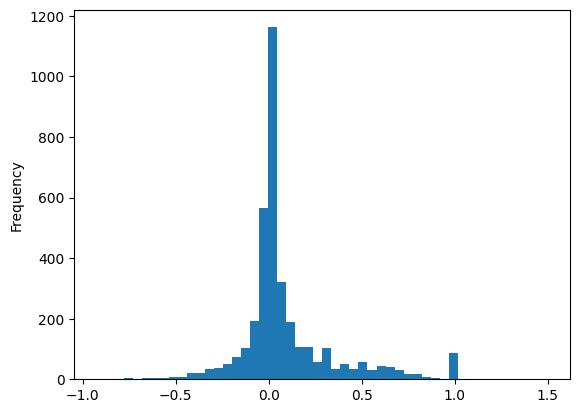

In [38]:
X_train_retro["requester_relative_consensual_votes_change"].plot(kind="hist", bins=50)

In [39]:
pd.crosstab(X_train_retro["request_was_legitimate_5percent"], yhat_train.astype(bool),
            normalize=True)

request_was_legitimate_prediction,False,True
request_was_legitimate_5percent,,
False,0.754675,0.089384
True,0.001100,0.154840


In [40]:
pd.crosstab(X_val_retro["request_was_legitimate_5percent"], yhat_val.astype(bool),
            normalize=True)

request_was_legitimate_prediction,False,True
request_was_legitimate_5percent,,
False,0.762376,0.084158
True,0.108911,0.044554


### Conclusion

According to the fact that requests were illegitimately labelled when the relative *(i.e. divided by total number of votes)* difference between up/down votes *(consensual/polarizing request)* changed downward over 5% at the moment of retrieval, it appears that some of our predictions were mislabelled.
Performances are quite satisfying given the modelisation context. Downgrades are probably due to our modelisation as we can observe it with the validation set, where false negatives bumped up from train to validation set.

# Project conclusion

Finally, non-textual and textual data were both important with their relative weights. But as expected, textual data is the heart of modelisation.
After many model and hypertuning trys, xgboost was a good candidate while combining it with a relevant preprocessing step. However, the algorithm is relatively strict about false negatives and leads to +/- poor recall performances.

In [41]:
pred_donation_pct = round(xgb_lotr_model.predict(X_test_lotr).sum() / len(xgb_lotr_model.predict(X_test_lotr)), 3) * 100
real_donation_pct = round(y.sum()/len(y), 3)*100

print(f'''From ground truth {round(y.sum()/len(y), 3)*100}% of request leading to donation, our algorithm predicted {pred_donation_pct}% of legitimate requests leading directly to donation.
It represents {round(pred_donation_pct/real_donation_pct, 3)*100}% of good calls on legitimate request.''')

From ground truth 24.6% of request leading to donation, our algorithm predicted 12.4% of legitimate requests leading directly to donation.
It represents 50.4% of good calls on legitimate request.
